In [2]:
# want to store this notebook in the notebooks folder, but want to keep non-relative imports
import os
os.chdir("../..")


/Users/martinweiss/.pyenv/versions/2.7.13/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [ ]:
import sys
import time
import copy

from scipy.stats import norm
from itertools import repeat
import data, data.gene_datasets
import sklearn, sklearn.model_selection, sklearn.metrics, sklearn.linear_model, sklearn.neural_network, sklearn.tree
import numpy as np
import matplotlib, matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import gene_inference
#from gene_inference.infer_genes import infer_all_genes, sample_neighbors
import models, models.graphLayer
from models.models import CGN
import data, data.gene_datasets
from data.graph import Graph
from data.utils import split_dataset
import optimization
import torch
from torch.autograd import Variable
from analysis.metrics import record_metrics_for_epoch
import analysis
reload(analysis.metrics)
reload(gene_inference);

In [3]:
tcgatissue = data.gene_datasets.TCGATissue(data_dir='./genomics/TCGA/', data_file='TCGA_tissue_ppi.hdf5')
#tcgatissue = data.gene_datasets.TCGATissue()

Converting one-hot labels to integers


In [4]:
class Object(object):
    pass

opt = Object()
opt.seed = 0
opt.nb_class = None
opt.nb_examples = None
opt.nb_nodes = None
opt.graph = "pathway"
opt.dataset = tcgatissue
opt.add_self = True
opt.norm_adj = True
opt.add_connectivity = False
opt.num_layer = 1
opt.cuda = True
opt.pool_graph = "ignore"


In [5]:
graph = Graph()
#path = "/data/lisa/data/genomics/graph/pancan-tissue-graph.hdf5"
path = "genomics/graph/pancan-tissue-graph.hdf5"
graph.load_graph(path)
#graph.intersection_with(tcgatissue)
g = nx.from_numpy_matrix(graph.adj)
mapping = dict(zip(range(0, len(tcgatissue.df.columns)), tcgatissue.df.columns))
g = nx.relabel_nodes(g, mapping)

In [6]:
def sample_neighbors(g, gene, num_neighbors, include_self=True):
    results = set([])
    if include_self:
        results = set([gene])
    all_nodes = set(g.nodes)
    first_degree = set(g.neighbors(gene))
    second_degree = set()
    for x in g.neighbors(gene):
        second_degree = second_degree.union(set(g.neighbors(x)))
    while len(results) < num_neighbors:
        if len(first_degree) - len(results) > 0:
            unique = sorted(first_degree - results)
            results.add(unique.pop())
        elif len(second_degree) - len(results) > 0:
            unique = sorted(second_degree - results)
            results.add(unique.pop())
        else:
            unique = sorted(all_nodes - results)
            results.add(unique.pop())
    return results

In [7]:
import sklearn, sklearn.model_selection, sklearn.metrics, sklearn.linear_model, sklearn.neural_network, sklearn.tree
import numpy as np

class Method:
    def __init__(self):
        pass

class SkLearn(Method):
    
    def __init__(self, model, penalty=False):
        self.model = model
        self.penalty = penalty
        
    def loop(self, dataset, seed, train_size, test_size, adj=None):
        
        X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(dataset.df, dataset.labels, stratify=dataset.labels, train_size=train_size, test_size=test_size, random_state=seed)

        if self.model == "LR":
            model = sklearn.linear_model.LogisticRegression()
            if self.penalty:
                model = sklearn.linear_model.LogisticRegression(penalty='l1', tol=0.0001)
        elif self.model == "DT":
            model = sklearn.tree.DecisionTreeClassifier()
        elif self.model == "MLP":
            model = sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(32,3), learning_rate_init=0.001, early_stopping=False,  max_iter=1000)
        else:
            print "incorrect label"
        
        model = model.fit(X_train, y_train)
        return sklearn.metrics.roc_auc_score(y_test, model.predict(X_test))


class PyTorch(Method):    
    
    def __init__(self, model, num_epochs=100, num_channel=16, num_layer=2, add_emb=8, use_gate=False, dropout=False, cuda=False):
        self.model = model
        self.batch_size = 10
        self.num_channel = num_channel
        self.num_layer = num_layer
        self.add_emb = add_emb
        self.use_gate = use_gate
        self.dropout = dropout
        self.cuda = cuda
        self.num_epochs = num_epochs
        self.patience = 10
        self.attention_head = 0
        
    def loop(self, dataset, seed, train_size, test_size, adj=None):
    
        X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(dataset.df, dataset.labels, stratify=dataset.labels, train_size=train_size, test_size=test_size, random_state=seed)
    
        #split train into valid and train
        if len(set(y_train)) == 1 or len(set(y_test)) == 1: 
            return
        try:
            local_X_train, local_X_valid, local_y_train, local_y_valid = sklearn.model_selection.train_test_split(X_train, y_train, stratify=y_train, train_size=0.60, random_state=seed)
        except Exception:
            return
        local_X_train = torch.FloatTensor(np.expand_dims(local_X_train, axis=2))
        local_X_valid = torch.FloatTensor(np.expand_dims(local_X_valid, axis=2))
        X_test = torch.FloatTensor(np.expand_dims(X_test, axis=2))
        
        local_y_train = torch.FloatTensor(local_y_train)

        criterion = optimization.get_criterion(dataset)
        l1_criterion = torch.nn.L1Loss(size_average=False)

        patience = self.patience
        opt.num_layer = self.num_layer
        #adj_transform, aggregate_function = models.graphLayer.get_transform(opt, adj)

        if self.model == "CGN":
            model = models.models.CGN(
                    nb_nodes=len(dataset.df.columns), 
                    input_dim=1,
                    channels=[self.num_channel] * self.num_layer,
                    adj=adj,
                    out_dim=2,
                    on_cuda=self.cuda,
                    add_emb=self.add_emb,
                    transform_adj=adj_transform,
                    aggregate_adj=aggregate_function,
                    use_gate=self.use_gate,
                    dropout=self.dropout,
                    attention_head=self.attention_head
                    )
        elif self.model == "MLP":
            model = models.models.MLP(
                    len(dataset.df.columns), 
                    channels=[self.num_channel] * self.num_layer, 
                    out_dim=2, 
                    on_cuda=self.cuda, 
                    dropout=self.dropout)
        elif self.model == "SLR":
            model = models.models.SparseLogisticRegression(
                    nb_nodes=len(dataset.df.columns), 
                    input_dim=1, 
                    adj=adj, 
                    out_dim=2, 
                    on_cuda=self.cuda)
        elif self.model == "LCG":
            model = models.models.LCG(
                    nb_nodes=len(dataset.df.columns), 
                    input_dim=1, 
                    channels=[self.num_channel] * self.num_layer,
                    adj=adj, 
                    out_dim=2,
                    on_cuda=self.cuda,
                    add_emb=self.add_emb,
                    transform_adj=adj_transform, 
                    aggregate_adj=aggregate_function, 
                    use_gate=self.use_gate,
                    dropout=self.dropout,
                    attention_head=nb_attention_head, 
                    training_mode=training_mode)
        elif self.model == 'LR':
            model = models.models.LogisticRegression(
                    nb_nodes=len(dataset.df.columns), 
                    input_dim=1, 
                    out_dim=2,
                    on_cuda=self.cuda)
            
        if self.cuda:
            torch.cuda.manual_seed(seed)
            torch.cuda.manual_seed_all(seed)
            model.cuda()
        
        #l1_loss_lambda = 0.0001
        #l1_criterion = torch.nn.L1Loss(size_average=False)

        optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
        max_valid = 0
        max_valid_test = 0
        for t in range(0, self.num_epochs):
            start_timer = time.time()
            
            for base_x in range(0,local_X_train.shape[0], self.batch_size):
                inputs, labels = local_X_train[base_x:base_x+self.batch_size], local_y_train[base_x:base_x+self.batch_size]

                inputs = Variable(inputs, requires_grad=False).float()
                if self.cuda:
                    inputs = inputs.cuda()
                    labels = labels.cuda()

                model.train()
                y_pred = model(inputs)

                # Compute and print loss
                crit_loss = optimization.compute_loss(criterion, y_pred, labels)
                #l1_loss = setup_l1_loss(model, l1_loss_lambda, l1_criterion, False)
                total_loss = crit_loss #+ l1_loss

                # Zero gradients, perform a backward pass, and update the weights.
                optimizer.zero_grad()
                crit_loss.backward()
                optimizer.step()
                model.eval()

            auc = {'train': 0., 'valid': 0., 'test': 0.}
            res = []
            try:
                for base_x in range(0,local_X_train.shape[0], self.batch_size):
                    inputs = Variable(local_X_train[base_x:base_x+self.batch_size], requires_grad=False).float()
                    res.append(model(inputs)[:,1].data.cpu().numpy())
                auc['train'] = sklearn.metrics.roc_auc_score(local_y_train.numpy(), np.asarray(res).flatten())

                res = []
                for base_x in range(0,local_X_valid.shape[0], self.batch_size):
                    inputs = Variable(local_X_valid[base_x:base_x+self.batch_size], requires_grad=False).float()
                    res.append(model(inputs)[:,1].data.cpu().numpy())
                auc['valid'] = sklearn.metrics.roc_auc_score(local_y_valid, np.asarray(res).flatten())

                res = []
                for base_x in range(0,X_test.shape[0], self.batch_size):
                    inputs = Variable(X_test[base_x:base_x+self.batch_size], requires_grad=False).float()
                    res.append(model(inputs)[:,1].data.cpu().numpy())
                auc['test'] = sklearn.metrics.roc_auc_score(y_test, np.asarray(res).flatten())
            except Exception:
                pass
            
            time_this_epoch = time.time() - start_timer

#eval on cpu
#             auc['train'] = sklearn.metrics.roc_auc_score(local_y_train.numpy(), model(Variable(local_X_train.cpu(), requires_grad=False).float())[:,1].cpu().data.numpy())
#             auc['valid'] = sklearn.metrics.roc_auc_score(local_y_valid, model(Variable(local_X_valid.cpu(), requires_grad=False).float())[:,1].cpu().data.numpy())
#             auc['test'] = sklearn.metrics.roc_auc_score(y_test, model(Variable(X_test.cpu(), requires_grad=False).float())[:,1].cpu().data.numpy())
            
            summary = [ t, crit_loss.data[0], auc['train'], auc['valid'], time_this_epoch ]
            summary = "epoch {}, cross_loss: {:.03f}, auc_train: {:0.3f}, auc_valid:{:0.3f}, time: {:.02f} sec".format(*summary)
            #print summary

            patience = patience - 1
            if patience == 0:
                return max_valid_test
                break
            if (max_valid < auc['valid']) and t > 5:
                max_valid = auc['valid']
                max_valid_test = auc['test']
                patience = self.patience

In [8]:
def method_comparison(results, dataset, models, gene, num_genes, trials, train_size, test_size):
    mean = dataset.df[gene].mean()
    dataset.labels = [1 if x > mean else 0 for x in dataset.df[gene]]
    if num_genes != len(dataset.df.columns):
        neighbors = sample_neighbors(g, gene, num_genes, include_self=True)
        dataset.df = dataset.df[list(neighbors)]
        
    dataset.df[gene] = 1
    dataset.data = dataset.df.as_matrix()
    # neighborhood = np.asarray(nx.to_numpy_matrix(nx.Graph(g.subgraph(neighbors))))
    neighborhood=None
    for model in models:
        for seed in range(trials):

            #have we already done it?
            already_done = results["df"][(results["df"].gene_name == gene) & 
                                         (results["df"].model == model['key']) &
                                         (results["df"].num_genes == num_genes) &
                                         (results["df"].seed == seed) &
                                         (results["df"].train_size == train_size)].shape[0] > 0

            if already_done:
                print "already done:", model['key'], num_genes, seed
                continue
            print "doing:", model['key'], num_genes, seed

            result = model['method'].loop(dataset=dataset, seed=seed, train_size=train_size, test_size=test_size, adj=neighborhood)

            experiment = {"gene_name": gene,
                    "model": model['key'],
                    "num_genes": num_genes, 
                    "seed":seed,
                    "train_size": train_size,
                    "auc":result
                    }

            results["df"] = results["df"].append(experiment, ignore_index=True)
            pickle.dump(results, open("results-temp.pkl", "wb"))
    #dataset.df = full_df


In [9]:
import pickle

m = [
#    {'key': 'LR-L1', 'method': SkLearn("LR", penalty=True)},
#    {'key': 'MLP', 'method': mlp},
#    {'key': 'DT', 'method': SkLearn("DT")},
#    {'key': 'new_CGN_3_layer_64_channel_emb_32_dropout', 'method': PyTorch("CGN")},
# {'key': 'wRPL5_CGN_3_layer_64_channel_emb_32_dropout', 'method': PyTorch("CGN")},
 #{'key': 'wRPL5_CGN_1_layer_32_channel_emb_32_dropout', 'method': PyTorch("CGN", num_layer=1, num_channel=32)},
    #{'key': 'MLP-dropout', 'method': PyTorch("MLP", dropout=True, cuda=False)},
    {'key': 'MLP', 'method': PyTorch("MLP", dropout=False, cuda=False)},
    {'key': 'LR', 'method': PyTorch("LR", dropout=False, cuda=False)},
    
    
#{'key': 'SLR', 'method': PyTorch("SLR")},
#   {'key': 'MLP', 'method': PyTorch("MLP", dropout=False)},
    ]



In [10]:
results = {"df": pd.DataFrame(columns=['auc','gene_name', 'model', 'num_genes', 'seed', 'train_size'])}

In [13]:
results = pickle.load(open("results_tuesday_morning.pkl", "r"))

In [15]:
tcgatissue = data.gene_datasets.TCGATissue(data_dir='./genomics/TCGA/', data_file='TCGA_tissue_ppi.hdf5')
tcgatissue.df = tcgatissue.df - tcgatissue.df.mean()

Converting one-hot labels to integers


In [16]:
genes_to_iter = tcgatissue.df.columns.difference(results['df']['gene_name'].unique())

In [17]:
full_df = tcgatissue.df.copy(deep=True)
for gene in genes_to_iter:
    tcgatissue.df = full_df[:1500]
    method_comparison(results, tcgatissue, m, gene=gene, num_genes=16300, trials=3, train_size=50, test_size=1000)
    tcgatissue.df = full_df[:1500]
    method_comparison(results, tcgatissue, m, gene=gene, num_genes=50, trials=3, train_size=50, test_size=1000)


/Users/martinweiss/.pyenv/versions/2.7.13/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


doing: MLP 16300 0


/Users/martinweiss/.pyenv/versions/2.7.13/lib/python2.7/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/martinweiss/.pyenv/versions/2.7.13/lib/python2.7/site-packages/ipykernel_launcher.py:188: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2

doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1

doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 

doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 1630

doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 

doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2

doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1

doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 

doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 1630

doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 

doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2

doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1

doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 

doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 1630

doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 

doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2

doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1

doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 

doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 1630

doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 

doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2

doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1

doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 

doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 1630

doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 

doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2

doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1

doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 

doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 1630

doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 

doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2

doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1

doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 

doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 1630

doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 

doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2

doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1

doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 

doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 1630

doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 

doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2

doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1

doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 

doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 1630

doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 

doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2

doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1

doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 

doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 1630

doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 

doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2

doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1

doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 

doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 1630

doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 

doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2

doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1

doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 

doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 1630

doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 

doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2

doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1

doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 

doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 1630

KeyboardInterrupt: 

NameError: name 'results' is not defined

In [20]:
results['df'].shape

(84274, 6)

In [18]:
#import pickle
#pickle.dump(results, open("results_wednesday_morning-pancan.pkl", "wb"))

In [66]:
results = pickle.load(open("results_wednesday_morning-pancan.pkl", "r"))

In [62]:
# 4 LINE DATA
std = 0.2
slice_size = 12


df = results['df']
grouped = df.groupby(['gene_name', 'model','train_size','num_genes'])['auc'].agg(['mean','std', 'count'])
small_neighborhood_mlp_df = df[df['num_genes'] == 50][df['model']=='MLP'].groupby(['gene_name', 'model','train_size'])['auc'].agg(['mean', 'std'])
big_neighborhood_mlp_df = df[df['num_genes'] == 16300][df['model']=='MLP'].groupby(['gene_name', 'model','train_size'])['auc'].agg(['mean', 'std'])
small_neighborhood_lr_df = df[df['num_genes'] == 50][df['model']=='LR'].groupby(['gene_name', 'model','train_size'])['auc'].agg(['mean', 'std'])
big_neighborhood_lr_df = df[df['num_genes'] == 16300][df['model']=='LR'].groupby(['gene_name', 'model','train_size'])['auc'].agg(['mean', 'std'])

# remove the genes with high variance
small_neighborhood_mlp_df = small_neighborhood_mlp_df[small_neighborhood_mlp_df['std'] < std]
big_neighborhood_mlp_df = big_neighborhood_mlp_df[big_neighborhood_mlp_df['std'] < std]
small_neighborhood_lr_df = small_neighborhood_lr_df[small_neighborhood_lr_df['std'] < std]
big_neighborhood_lr_df = big_neighborhood_lr_df[big_neighborhood_lr_df['std'] < std]

# reset the index to the gene names (I don't like working with hierarchical indices)
small_neighborhood_mlp_df.index = small_neighborhood_mlp_df.index.get_level_values(0)
big_neighborhood_mlp_df.index = big_neighborhood_mlp_df.index.get_level_values(0)
small_neighborhood_lr_df.index = small_neighborhood_lr_df.index.get_level_values(0)
big_neighborhood_lr_df.index = big_neighborhood_lr_df.index.get_level_values(0)

# Find the genes which are low variance in the small neighborhood and large neighborhood dfs
intersection_mlp = big_neighborhood_mlp_df.index.intersection(small_neighborhood_mlp_df.index)
intersection_lr = big_neighborhood_lr_df.index.intersection(small_neighborhood_lr_df.index)
intersection = intersection_lr.intersection(intersection_mlp)

big_neighborhood_mlp_intersection_df = big_neighborhood_mlp_df[big_neighborhood_mlp_df.index.isin(intersection)]
small_neighborhood_mlp_intersection_df = small_neighborhood_mlp_df[small_neighborhood_mlp_df.index.isin(intersection)]
mlp_low_var_high_mean_df = small_neighborhood_mlp_intersection_df.sub(big_neighborhood_mlp_intersection_df).sort_values('mean', ascending=False)

big_neighborhood_lr_intersection_df = big_neighborhood_lr_df[big_neighborhood_lr_df.index.isin(intersection)]
small_neighborhood_lr_intersection_df = small_neighborhood_lr_df[small_neighborhood_lr_df.index.isin(intersection)]
lr_low_var_high_mean_df = small_neighborhood_lr_intersection_df.sub(big_neighborhood_lr_intersection_df).sort_values('mean', ascending=False)

index_order = lr_low_var_high_mean_df.index[0:slice_size]

line1_big_mlp = big_neighborhood_mlp_intersection_df[big_neighborhood_mlp_intersection_df.index.isin(index_order)]
line2_small_mlp = small_neighborhood_mlp_intersection_df[small_neighborhood_mlp_intersection_df.index.isin(index_order)]
line3_big_lr = big_neighborhood_lr_intersection_df[big_neighborhood_lr_intersection_df.index.isin(index_order)]
line4_small_lr = small_neighborhood_lr_intersection_df[small_neighborhood_lr_intersection_df.index.isin(index_order)]

line1 = line1_big_mlp.loc[index_order.tolist()]
line2 = line2_small_mlp.loc[index_order.tolist()]
line3 = line3_big_lr.loc[index_order.tolist()]
line4 = line4_small_lr.loc[index_order.tolist()]


/Users/martinweiss/.pyenv/versions/2.7.13/lib/python2.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/martinweiss/.pyenv/versions/2.7.13/lib/python2.7/site-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/Users/martinweiss/.pyenv/versions/2.7.13/lib/python2.7/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/Users/martinweiss/.pyenv/versions/2.7.13/lib/python2.7/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


ValueError: shape mismatch: objects cannot be broadcast to a single shape

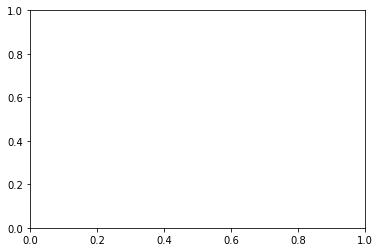

In [63]:
%matplotlib inline
plt.errorbar(range(0, slice_size), line1['mean'], label="MLP - All Genes", xerr=0, yerr=line1_big_mlp['std'])
plt.errorbar(range(0, slice_size), line2['mean'], label="MLP - 50 Neighbors", xerr=0, yerr=line2_small_mlp['std'])
plt.errorbar(range(0, slice_size), line3['mean'], label="LR - All Genes", xerr=0, yerr=line3_big_lr['std'])
plt.errorbar(range(0, slice_size), line4['mean'], label="LR - 50 Neighbors", xerr=0, yerr=line4_small_lr['std'])

plt.title("Inference of Gene Expression with Varying Input Genes")
plt.ylabel("AUC")
plt.xlabel("Gene Names")
plt.xticks(np.arange(slice_size), index_order, rotation=70)
plt.legend();

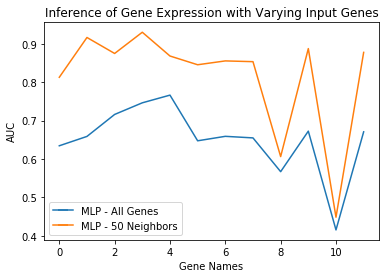

In [444]:
%matplotlib inline
plt.errorbar(range(0, slice_size), line1['mean'], label="MLP - All Genes", xerr=0) #yerr=line1_big_mlp['std'])
plt.errorbar(range(0, slice_size), line2['mean'], label="MLP - 50 Neighbors", xerr=0)#, yerr=line2_small_mlp['std'])

plt.title("Inference of Gene Expression with Varying Input Genes")
plt.ylabel("AUC")
plt.xlabel("Gene Names")
#plt.xticks(np.arange(slice_size), index_order, rotation=70)
plt.legend();

In [72]:
# 2 LINE DATA

###### IF you want switch to plotting the LR model instead of the MLP, just flip the commented lines below
std = .20
slice_size = 100000


df = results['df']
grouped = df.groupby(['gene_name', 'model','train_size','num_genes'])['auc'].agg(['mean','std', 'count'])
small_neighborhood_mlp_df = df[df['num_genes'] == 50][df['model']=='MLP'].groupby(['gene_name', 'model','train_size'])['auc'].agg(['mean', 'std'])
big_neighborhood_mlp_df = df[df['num_genes'] == 16300][df['model']=='MLP'].groupby(['gene_name', 'model','train_size'])['auc'].agg(['mean', 'std'])
small_neighborhood_lr_df = df[df['num_genes'] == 50][df['model']=='LR'].groupby(['gene_name', 'model','train_size'])['auc'].agg(['mean', 'std'])
big_neighborhood_lr_df = df[df['num_genes'] == 16300][df['model']=='LR'].groupby(['gene_name', 'model','train_size'])['auc'].agg(['mean', 'std'])

# remove the genes with high variance
small_neighborhood_mlp_df = small_neighborhood_mlp_df[small_neighborhood_mlp_df['std'] < std]
big_neighborhood_mlp_df = big_neighborhood_mlp_df[big_neighborhood_mlp_df['std'] < std]
small_neighborhood_lr_df = small_neighborhood_lr_df[small_neighborhood_lr_df['std'] < std]
big_neighborhood_lr_df = big_neighborhood_lr_df[big_neighborhood_lr_df['std'] < std]

# reset the index to the gene names (I don't like working with hierarchical indices)
small_neighborhood_mlp_df.index = small_neighborhood_mlp_df.index.get_level_values(0)
big_neighborhood_mlp_df.index = big_neighborhood_mlp_df.index.get_level_values(0)
small_neighborhood_lr_df.index = small_neighborhood_lr_df.index.get_level_values(0)
big_neighborhood_lr_df.index = big_neighborhood_lr_df.index.get_level_values(0)

# Find the genes which are low variance in the small neighborhood and large neighborhood dfs
intersection = big_neighborhood_mlp_df.index.intersection(small_neighborhood_mlp_df.index)
#intersection = big_neighborhood_lr_df.index.intersection(small_neighborhood_lr_df.index)

big_neighborhood_mlp_intersection_df = big_neighborhood_mlp_df[big_neighborhood_mlp_df.index.isin(intersection)]
small_neighborhood_mlp_intersection_df = small_neighborhood_mlp_df[small_neighborhood_mlp_df.index.isin(intersection)]
mlp_low_var_high_mean_df = small_neighborhood_mlp_intersection_df.sub(big_neighborhood_mlp_intersection_df).sort_values('mean', ascending=False)

#big_neighborhood_lr_intersection_df = big_neighborhood_lr_df[big_neighborhood_lr_df.index.isin(intersection)]
#small_neighborhood_lr_intersection_df = small_neighborhood_lr_df[small_neighborhood_lr_df.index.isin(intersection)]
#lr_low_var_high_mean_df = small_neighborhood_lr_intersection_df.sub(big_neighborhood_lr_intersection_df).sort_values('mean', ascending=False)

index_order = mlp_low_var_high_mean_df.index[0:slice_size]
#index_order = lr_low_var_high_mean_df.index[0:slice_size]

line1 = big_neighborhood_mlp_intersection_df[big_neighborhood_mlp_intersection_df.index.isin(index_order)].loc[index_order.tolist()]
line2 = small_neighborhood_mlp_intersection_df[small_neighborhood_mlp_intersection_df.index.isin(index_order)].loc[index_order.tolist()]
#line1 = big_neighborhood_lr_intersection_df[big_neighborhood_lr_intersection_df.index.isin(index_order)].loc[index_order.tolist()]
#line2 = small_neighborhood_lr_intersection_df[small_neighborhood_lr_intersection_df.index.isin(index_order)].loc[index_order.tolist()]



/Users/martinweiss/.pyenv/versions/2.7.13/lib/python2.7/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/Users/martinweiss/.pyenv/versions/2.7.13/lib/python2.7/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/Users/martinweiss/.pyenv/versions/2.7.13/lib/python2.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/Users/martinweiss/.pyenv/versions/2.7.13/lib/python2.7/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]


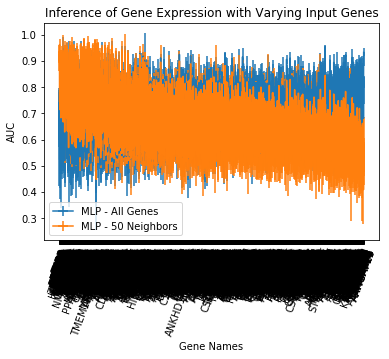

In [77]:
%matplotlib inline
plt.errorbar(range(len(line1)), line1['mean'], label="MLP - All Genes", xerr=0, yerr=line1['std'])
plt.errorbar(range(len(line2)), line2['mean'], label="MLP - 50 Neighbors", xerr=0, yerr=line2['std']) #range(0, slice_size),

plt.title("Inference of Gene Expression with Varying Input Genes")
plt.ylabel("AUC")
plt.xlabel("Gene Names")
plt.xticks(np.arange(len(index_order)), index_order, rotation=70)
plt.legend();

None


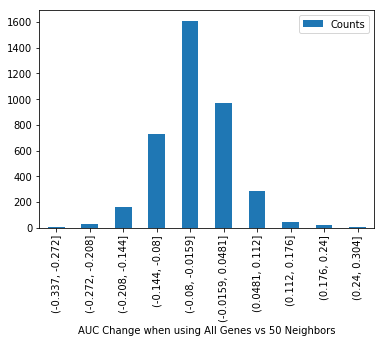

In [508]:
mlp_low_var_high_mean_df['bucket'] = pd.cut(mlp_low_var_high_mean_df['mean'], 10)
newdf = mlp_low_var_high_mean_df[['bucket', 'mean']].groupby('bucket').agg('count')
newdf.index.name = 'AUC Change when using All Genes vs 50 Neighbors'
print newdf.rename(index=str, columns={'mean': 'Counts'}, inplace=True)
newdf.plot(kind='bar')


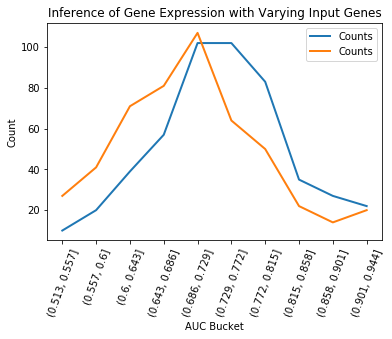

In [33]:
line1['bucket'] = pd.cut(line1['mean'], 10)
line2['bucket'] = pd.cut(line2['mean'], 10)
newdf1 = line1[['bucket', 'mean']].groupby('bucket').agg('count')
newdf2 = line2[['bucket', 'mean']].groupby('bucket').agg('count')
newdf1.index.name = 'AUC Change when using All Genes vs 50 Neighbors'
newdf1.rename(index=str, columns={'mean': 'Counts'}, inplace=True)
newdf2.index.name = 'AUC Change when using All Genes vs 50 Neighbors'
newdf2.rename(index=str, columns={'mean': 'Counts'}, inplace=True)
plt.plot(range(len(newdf1)), newdf1['Counts'], linewidth=2)
plt.plot(range(len(newdf2)), newdf2['Counts'], linewidth=2)
plt.title("Inference of Gene Expression with Varying Input Genes")
plt.ylabel("Count")
plt.xlabel("AUC Bucket")
plt.xticks(range(len(newdf1)), newdf1.index, rotation=70)
plt.legend();

In [588]:
import matplotlib.mlab as mlab


In [84]:
# Setup for the graphs I was showing... took a slice.

###### IF you want switch to plotting the LR model instead of the MLP, just flip the commented lines below
std = .20
slice_size = 1000


df = results['df']
grouped = df.groupby(['gene_name', 'model','train_size','num_genes'])['auc'].agg(['mean','std', 'count'])
small_neighborhood_mlp_df = df[df['num_genes'] == 50][df['model']=='MLP'].groupby(['gene_name', 'model','train_size'])['auc'].agg(['mean', 'std'])
big_neighborhood_mlp_df = df[df['num_genes'] == 16300][df['model']=='MLP'].groupby(['gene_name', 'model','train_size'])['auc'].agg(['mean', 'std'])
small_neighborhood_lr_df = df[df['num_genes'] == 50][df['model']=='LR'].groupby(['gene_name', 'model','train_size'])['auc'].agg(['mean', 'std'])
big_neighborhood_lr_df = df[df['num_genes'] == 16300][df['model']=='LR'].groupby(['gene_name', 'model','train_size'])['auc'].agg(['mean', 'std'])

# remove the genes with high variance
small_neighborhood_mlp_df = small_neighborhood_mlp_df[small_neighborhood_mlp_df['std'] < std]
big_neighborhood_mlp_df = big_neighborhood_mlp_df[big_neighborhood_mlp_df['std'] < std]
small_neighborhood_lr_df = small_neighborhood_lr_df[small_neighborhood_lr_df['std'] < std]
big_neighborhood_lr_df = big_neighborhood_lr_df[big_neighborhood_lr_df['std'] < std]

# reset the index to the gene names (I don't like working with hierarchical indices)
small_neighborhood_mlp_df.index = small_neighborhood_mlp_df.index.get_level_values(0)
big_neighborhood_mlp_df.index = big_neighborhood_mlp_df.index.get_level_values(0)
small_neighborhood_lr_df.index = small_neighborhood_lr_df.index.get_level_values(0)
big_neighborhood_lr_df.index = big_neighborhood_lr_df.index.get_level_values(0)

# Find the genes which are low variance in the small neighborhood and large neighborhood dfs
intersection = big_neighborhood_mlp_df.index.intersection(small_neighborhood_mlp_df.index)
#intersection = big_neighborhood_lr_df.index.intersection(small_neighborhood_lr_df.index)

big_neighborhood_mlp_intersection_df = big_neighborhood_mlp_df[big_neighborhood_mlp_df.index.isin(intersection)]
small_neighborhood_mlp_intersection_df = small_neighborhood_mlp_df[small_neighborhood_mlp_df.index.isin(intersection)]
mlp_low_var_high_mean_df = small_neighborhood_mlp_intersection_df.sub(big_neighborhood_mlp_intersection_df).sort_values('mean', ascending=False)

#big_neighborhood_lr_intersection_df = big_neighborhood_lr_df[big_neighborhood_lr_df.index.isin(intersection)]
#small_neighborhood_lr_intersection_df = small_neighborhood_lr_df[small_neighborhood_lr_df.index.isin(intersection)]
#lr_low_var_high_mean_df = small_neighborhood_lr_intersection_df.sub(big_neighborhood_lr_intersection_df).sort_values('mean', ascending=False)

index_order = mlp_low_var_high_mean_df.index[0:slice_size]
#index_order = lr_low_var_high_mean_df.index[0:slice_size]

line1 = big_neighborhood_mlp_intersection_df[big_neighborhood_mlp_intersection_df.index.isin(index_order)].loc[index_order.tolist()]
line2 = small_neighborhood_mlp_intersection_df[small_neighborhood_mlp_intersection_df.index.isin(index_order)].loc[index_order.tolist()]
#line1 = big_neighborhood_lr_intersection_df[big_neighborhood_lr_intersection_df.index.isin(index_order)].loc[index_order.tolist()]
#line2 = small_neighborhood_lr_intersection_df[small_neighborhood_lr_intersection_df.index.isin(index_order)].loc[index_order.tolist()]



/Users/martinweiss/.pyenv/versions/2.7.13/lib/python2.7/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/Users/martinweiss/.pyenv/versions/2.7.13/lib/python2.7/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/Users/martinweiss/.pyenv/versions/2.7.13/lib/python2.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/Users/martinweiss/.pyenv/versions/2.7.13/lib/python2.7/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]


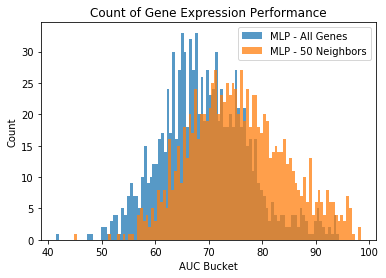

In [85]:
l1 = line1['mean'] * 100
l2 = line2['mean'] * 100
line1
line2

fig, ax = plt.subplots()
n1, bins1, patches1 = ax.hist(l1, 100, label="MLP - All Genes", density=0, alpha=0.75)
n2, bins2, patches2 = ax.hist(l2, 100, label="MLP - 50 Neighbors", density=0, alpha=0.75)

#plt.plot(1000, y1['mean'], 'r--', linewidth=2)
#plt.plot(100, y2, 'b--', linewidth=2)

plt.title("Count of Gene Expression Performance")
plt.ylabel("Count")
plt.xlabel("AUC Bucket")

plt.legend()
plt.show()


In [611]:
(mu1, sigma1) = norm.fit(line1['mean'])
#(mu2, sigma2) = norm.fit(line2['mean'])
y1 = mlab.normpdf(bins1, mu1, sigma1)
#y2 = mlab.normpdf(bins2, mu2, sigma2)
print bins1


[41.5026455  42.03145892 42.56027234 43.08908575 43.61789917 44.14671259
 44.67552601 45.20433942 45.73315284 46.26196626 46.79077968 47.31959309
 47.84840651 48.37721993 48.90603335 49.43484676 49.96366018 50.4924736
 51.02128702 51.55010043 52.07891385 52.60772727 53.13654069 53.6653541
 54.19416752 54.72298094 55.25179436 55.78060777 56.30942119 56.83823461
 57.36704803 57.89586144 58.42467486 58.95348828 59.4823017  60.01111511
 60.53992853 61.06874195 61.59755537 62.12636878 62.6551822  63.18399562
 63.71280904 64.24162245 64.77043587 65.29924929 65.82806271 66.35687612
 66.88568954 67.41450296 67.94331637 68.47212979 69.00094321 69.52975663
 70.05857004 70.58738346 71.11619688 71.6450103  72.17382371 72.70263713
 73.23145055 73.76026397 74.28907738 74.8178908  75.34670422 75.87551764
 76.40433105 76.93314447 77.46195789 77.99077131 78.51958472 79.04839814
 79.57721156 80.10602498 80.63483839 81.16365181 81.69246523 82.22127865
 82.75009206 83.27890548 83.8077189  84.33653232 84.8

In [90]:
# Setup for the graphs I was showing... took a slice.

###### IF you want switch to plotting the LR model instead of the MLP, just flip the commented lines below
std = .20
slice_size = 1000


df = results['df']
grouped = df.groupby(['gene_name', 'model','train_size','num_genes'])['auc'].agg(['mean','std', 'count'])
small_neighborhood_mlp_df = df[df['num_genes'] == 50][df['model']=='MLP'].groupby(['gene_name', 'model','train_size'])['auc'].agg(['mean', 'std'])
big_neighborhood_mlp_df = df[df['num_genes'] == 16300][df['model']=='MLP'].groupby(['gene_name', 'model','train_size'])['auc'].agg(['mean', 'std'])
small_neighborhood_lr_df = df[df['num_genes'] == 50][df['model']=='LR'].groupby(['gene_name', 'model','train_size'])['auc'].agg(['mean', 'std'])
big_neighborhood_lr_df = df[df['num_genes'] == 16300][df['model']=='LR'].groupby(['gene_name', 'model','train_size'])['auc'].agg(['mean', 'std'])

# remove the genes with high variance
small_neighborhood_mlp_df = small_neighborhood_mlp_df[small_neighborhood_mlp_df['std'] < std]
big_neighborhood_mlp_df = big_neighborhood_mlp_df[big_neighborhood_mlp_df['std'] < std]
small_neighborhood_lr_df = small_neighborhood_lr_df[small_neighborhood_lr_df['std'] < std]
big_neighborhood_lr_df = big_neighborhood_lr_df[big_neighborhood_lr_df['std'] < std]

# reset the index to the gene names (I don't like working with hierarchical indices)
small_neighborhood_mlp_df.index = small_neighborhood_mlp_df.index.get_level_values(0)
big_neighborhood_mlp_df.index = big_neighborhood_mlp_df.index.get_level_values(0)
small_neighborhood_lr_df.index = small_neighborhood_lr_df.index.get_level_values(0)
big_neighborhood_lr_df.index = big_neighborhood_lr_df.index.get_level_values(0)

# Find the genes which are low variance in the small neighborhood and large neighborhood dfs
intersection = big_neighborhood_mlp_df.index.intersection(small_neighborhood_mlp_df.index)
#intersection = big_neighborhood_lr_df.index.intersection(small_neighborhood_lr_df.index)

big_neighborhood_mlp_intersection_df = big_neighborhood_mlp_df[big_neighborhood_mlp_df.index.isin(intersection)]
small_neighborhood_mlp_intersection_df = small_neighborhood_mlp_df[small_neighborhood_mlp_df.index.isin(intersection)]
mlp_low_var_high_mean_df = small_neighborhood_mlp_intersection_df.sub(big_neighborhood_mlp_intersection_df).sort_values('mean', ascending=False)

#big_neighborhood_lr_intersection_df = big_neighborhood_lr_df[big_neighborhood_lr_df.index.isin(intersection)]
#small_neighborhood_lr_intersection_df = small_neighborhood_lr_df[small_neighborhood_lr_df.index.isin(intersection)]
#lr_low_var_high_mean_df = small_neighborhood_lr_intersection_df.sub(big_neighborhood_lr_intersection_df).sort_values('mean', ascending=False)

index_order = mlp_low_var_high_mean_df.index[0:slice_size]
#index_order = lr_low_var_high_mean_df.index[0:slice_size]

line1 = big_neighborhood_mlp_intersection_df[big_neighborhood_mlp_intersection_df.index.isin(index_order)].loc[index_order.tolist()]
line2 = small_neighborhood_mlp_intersection_df[small_neighborhood_mlp_intersection_df.index.isin(index_order)].loc[index_order.tolist()]
#line1 = big_neighborhood_lr_intersection_df[big_neighborhood_lr_intersection_df.index.isin(index_order)].loc[index_order.tolist()]
#line2 = small_neighborhood_lr_intersection_df[small_neighborhood_lr_intersection_df.index.isin(index_order)].loc[index_order.tolist()]



/Users/martinweiss/.pyenv/versions/2.7.13/lib/python2.7/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/Users/martinweiss/.pyenv/versions/2.7.13/lib/python2.7/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/Users/martinweiss/.pyenv/versions/2.7.13/lib/python2.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/Users/martinweiss/.pyenv/versions/2.7.13/lib/python2.7/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]


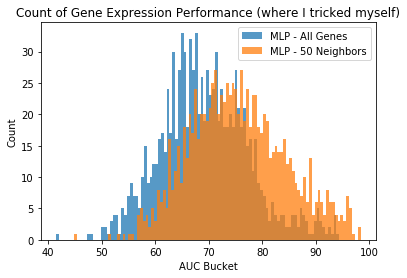

In [92]:
l1 = line1['mean'] * 100
l2 = line2['mean'] * 100
line1
line2

fig, ax = plt.subplots()
n1, bins1, patches1 = ax.hist(l1, 100, label="MLP - All Genes", density=0, alpha=0.75)
n2, bins2, patches2 = ax.hist(l2, 100, label="MLP - 50 Neighbors", density=0, alpha=0.75)

#plt.plot(1000, y1['mean'], 'r--', linewidth=2)
#plt.plot(100, y2, 'b--', linewidth=2)

plt.title("Count of Gene Expression Performance (where I tricked myself)")
plt.ylabel("Count")
plt.xlabel("AUC Bucket")

plt.legend()
plt.show()


In [96]:
# Setup for the graphs I was showing... took a slice.

###### IF you want switch to plotting the LR model instead of the MLP, just flip the commented lines below
std = 1.0
slice_size = 100000


df = results['df']
grouped = df.groupby(['gene_name', 'model','train_size','num_genes'])['auc'].agg(['mean','std', 'count'])
small_neighborhood_mlp_df = df[df['num_genes'] == 50][df['model']=='MLP'].groupby(['gene_name', 'model','train_size'])['auc'].agg(['mean', 'std'])
big_neighborhood_mlp_df = df[df['num_genes'] == 16300][df['model']=='MLP'].groupby(['gene_name', 'model','train_size'])['auc'].agg(['mean', 'std'])
small_neighborhood_lr_df = df[df['num_genes'] == 50][df['model']=='LR'].groupby(['gene_name', 'model','train_size'])['auc'].agg(['mean', 'std'])
big_neighborhood_lr_df = df[df['num_genes'] == 16300][df['model']=='LR'].groupby(['gene_name', 'model','train_size'])['auc'].agg(['mean', 'std'])

# remove the genes with high variance
small_neighborhood_mlp_df = small_neighborhood_mlp_df[small_neighborhood_mlp_df['std'] < std]
big_neighborhood_mlp_df = big_neighborhood_mlp_df[big_neighborhood_mlp_df['std'] < std]
small_neighborhood_lr_df = small_neighborhood_lr_df[small_neighborhood_lr_df['std'] < std]
big_neighborhood_lr_df = big_neighborhood_lr_df[big_neighborhood_lr_df['std'] < std]

# reset the index to the gene names (I don't like working with hierarchical indices)
small_neighborhood_mlp_df.index = small_neighborhood_mlp_df.index.get_level_values(0)
big_neighborhood_mlp_df.index = big_neighborhood_mlp_df.index.get_level_values(0)
small_neighborhood_lr_df.index = small_neighborhood_lr_df.index.get_level_values(0)
big_neighborhood_lr_df.index = big_neighborhood_lr_df.index.get_level_values(0)

# Find the genes which are low variance in the small neighborhood and large neighborhood dfs
#intersection = big_neighborhood_mlp_df.index.intersection(small_neighborhood_mlp_df.index)
intersection = big_neighborhood_lr_df.index.intersection(small_neighborhood_lr_df.index)

#big_neighborhood_mlp_intersection_df = big_neighborhood_mlp_df[big_neighborhood_mlp_df.index.isin(intersection)]
#small_neighborhood_mlp_intersection_df = small_neighborhood_mlp_df[small_neighborhood_mlp_df.index.isin(intersection)]
#mlp_low_var_high_mean_df = small_neighborhood_mlp_intersection_df.sub(big_neighborhood_mlp_intersection_df).sort_values('mean', ascending=False)

big_neighborhood_lr_intersection_df = big_neighborhood_lr_df[big_neighborhood_lr_df.index.isin(intersection)]
small_neighborhood_lr_intersection_df = small_neighborhood_lr_df[small_neighborhood_lr_df.index.isin(intersection)]
lr_low_var_high_mean_df = small_neighborhood_lr_intersection_df.sub(big_neighborhood_lr_intersection_df).sort_values('mean', ascending=False)

#index_order = mlp_low_var_high_mean_df.index[0:slice_size]
index_order = lr_low_var_high_mean_df.index[0:slice_size]

#line1 = big_neighborhood_mlp_intersection_df[big_neighborhood_mlp_intersection_df.index.isin(index_order)].loc[index_order.tolist()]
#line2 = small_neighborhood_mlp_intersection_df[small_neighborhood_mlp_intersection_df.index.isin(index_order)].loc[index_order.tolist()]
line1 = big_neighborhood_lr_intersection_df[big_neighborhood_lr_intersection_df.index.isin(index_order)].loc[index_order.tolist()]
line2 = small_neighborhood_lr_intersection_df[small_neighborhood_lr_intersection_df.index.isin(index_order)].loc[index_order.tolist()]


/Users/martinweiss/.pyenv/versions/2.7.13/lib/python2.7/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/Users/martinweiss/.pyenv/versions/2.7.13/lib/python2.7/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/Users/martinweiss/.pyenv/versions/2.7.13/lib/python2.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/Users/martinweiss/.pyenv/versions/2.7.13/lib/python2.7/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]


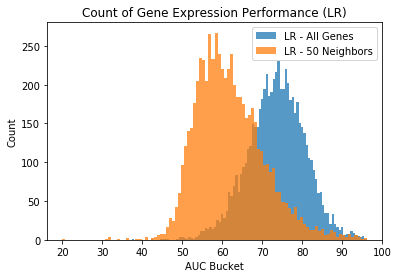

In [97]:
l1 = line1['mean'] * 100
l2 = line2['mean'] * 100
line1
line2

fig, ax = plt.subplots()
n1, bins1, patches1 = ax.hist(l1, 100, label="LR - All Genes", density=0, alpha=0.75)
n2, bins2, patches2 = ax.hist(l2, 100, label="LR - 50 Neighbors", density=0, alpha=0.75)

#plt.plot(1000, y1['mean'], 'r--', linewidth=2)
#plt.plot(100, y2, 'b--', linewidth=2)

plt.title("Count of Gene Expression Performance (LR)")
plt.ylabel("Count")
plt.xlabel("AUC Bucket")

plt.legend()
plt.show()


In [98]:
# Setup for the graphs I was showing... took a slice.

###### IF you want switch to plotting the LR model instead of the MLP, just flip the commented lines below
std = 1.0
slice_size = 100000


df = results['df']
grouped = df.groupby(['gene_name', 'model','train_size','num_genes'])['auc'].agg(['mean','std', 'count'])
small_neighborhood_mlp_df = df[df['num_genes'] == 50][df['model']=='MLP'].groupby(['gene_name', 'model','train_size'])['auc'].agg(['mean', 'std'])
big_neighborhood_mlp_df = df[df['num_genes'] == 16300][df['model']=='MLP'].groupby(['gene_name', 'model','train_size'])['auc'].agg(['mean', 'std'])
small_neighborhood_lr_df = df[df['num_genes'] == 50][df['model']=='LR'].groupby(['gene_name', 'model','train_size'])['auc'].agg(['mean', 'std'])
big_neighborhood_lr_df = df[df['num_genes'] == 16300][df['model']=='LR'].groupby(['gene_name', 'model','train_size'])['auc'].agg(['mean', 'std'])

# remove the genes with high variance
small_neighborhood_mlp_df = small_neighborhood_mlp_df[small_neighborhood_mlp_df['std'] < std]
big_neighborhood_mlp_df = big_neighborhood_mlp_df[big_neighborhood_mlp_df['std'] < std]
small_neighborhood_lr_df = small_neighborhood_lr_df[small_neighborhood_lr_df['std'] < std]
big_neighborhood_lr_df = big_neighborhood_lr_df[big_neighborhood_lr_df['std'] < std]

# reset the index to the gene names (I don't like working with hierarchical indices)
small_neighborhood_mlp_df.index = small_neighborhood_mlp_df.index.get_level_values(0)
big_neighborhood_mlp_df.index = big_neighborhood_mlp_df.index.get_level_values(0)
small_neighborhood_lr_df.index = small_neighborhood_lr_df.index.get_level_values(0)
big_neighborhood_lr_df.index = big_neighborhood_lr_df.index.get_level_values(0)

# Find the genes which are low variance in the small neighborhood and large neighborhood dfs
intersection = big_neighborhood_mlp_df.index.intersection(small_neighborhood_mlp_df.index)
#intersection = big_neighborhood_lr_df.index.intersection(small_neighborhood_lr_df.index)

big_neighborhood_mlp_intersection_df = big_neighborhood_mlp_df[big_neighborhood_mlp_df.index.isin(intersection)]
small_neighborhood_mlp_intersection_df = small_neighborhood_mlp_df[small_neighborhood_mlp_df.index.isin(intersection)]
mlp_low_var_high_mean_df = small_neighborhood_mlp_intersection_df.sub(big_neighborhood_mlp_intersection_df).sort_values('mean', ascending=False)

#big_neighborhood_lr_intersection_df = big_neighborhood_lr_df[big_neighborhood_lr_df.index.isin(intersection)]
#small_neighborhood_lr_intersection_df = small_neighborhood_lr_df[small_neighborhood_lr_df.index.isin(intersection)]
#lr_low_var_high_mean_df = small_neighborhood_lr_intersection_df.sub(big_neighborhood_lr_intersection_df).sort_values('mean', ascending=False)

index_order = mlp_low_var_high_mean_df.index[0:slice_size]
#index_order = lr_low_var_high_mean_df.index[0:slice_size]

line1 = big_neighborhood_mlp_intersection_df[big_neighborhood_mlp_intersection_df.index.isin(index_order)].loc[index_order.tolist()]
line2 = small_neighborhood_mlp_intersection_df[small_neighborhood_mlp_intersection_df.index.isin(index_order)].loc[index_order.tolist()]
#line1 = big_neighborhood_lr_intersection_df[big_neighborhood_lr_intersection_df.index.isin(index_order)].loc[index_order.tolist()]
#line2 = small_neighborhood_lr_intersection_df[small_neighborhood_lr_intersection_df.index.isin(index_order)].loc[index_order.tolist()]


/Users/martinweiss/.pyenv/versions/2.7.13/lib/python2.7/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/Users/martinweiss/.pyenv/versions/2.7.13/lib/python2.7/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/Users/martinweiss/.pyenv/versions/2.7.13/lib/python2.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/Users/martinweiss/.pyenv/versions/2.7.13/lib/python2.7/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]


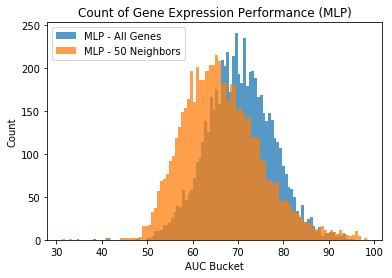

In [100]:
l1 = line1['mean'] * 100
l2 = line2['mean'] * 100
line1
line2

fig, ax = plt.subplots()
n1, bins1, patches1 = ax.hist(l1, 100, label="MLP - All Genes", density=0, alpha=0.75)
n2, bins2, patches2 = ax.hist(l2, 100, label="MLP - 50 Neighbors", density=0, alpha=0.75)

#plt.plot(1000, y1['mean'], 'r--', linewidth=2)
#plt.plot(100, y2, 'b--', linewidth=2)

plt.title("Count of Gene Expression Performance (MLP)")
plt.ylabel("Count")
plt.xlabel("AUC Bucket")

plt.legend()
plt.show()
